In [1]:
import os
import json
import random
import tarfile
import tempfile
import subprocess
from pathlib import Path
from datetime import datetime

from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Dict, List, Union
import torch

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# HF dataset repo
REPO_ID = "DigitalUmuganda/ASR_Fellowship_Challenge_Dataset"

#train split
TRAIN_PREFIX = "train_tarred/sharded_manifests_with_image"

#shards/manifests to use
SHARD_INDICES = [0, 1, 2]   # first 3 shards

#targt samples
TOTAL_TARGET_SAMPLES = 1000

#consistency/reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

#storing my sample/subset on google drive
BASE_DRIVE_DIR = "/content/drive/MyDrive/du_asr_subset"
AUDIO_OUT_DIR = os.path.join(BASE_DRIVE_DIR, "wav_16k")
META_OUT_DIR = os.path.join(BASE_DRIVE_DIR, "metadata")

os.makedirs(AUDIO_OUT_DIR, exist_ok=True)
os.makedirs(META_OUT_DIR, exist_ok=True)

print("Base subset dir:", BASE_DRIVE_DIR)
print("Audio out dir  :", AUDIO_OUT_DIR)
print("Meta out dir   :", META_OUT_DIR)
print("Shards         :", SHARD_INDICES)
print("Target samples :", TOTAL_TARGET_SAMPLES)


Base subset dir: /content/drive/MyDrive/du_asr_subset
Audio out dir  : /content/drive/MyDrive/du_asr_subset/wav_16k
Meta out dir   : /content/drive/MyDrive/du_asr_subset/metadata
Shards         : [0, 1, 2]
Target samples : 1000


In [ ]:
#If different keys printed, just change these.
KEY_AUDIO_PATH = "audio_filepath"   #path inside audio shard
KEY_TEXT       = "text"             #transcription text

#metadata keys to keep
OPTIONAL_META_KEYS = [
    "raw_text",
    "duration",
    "LUFS",
    "age_group",
    "gender",
    "location",
]

all_candidates = []   # each item: dict with shard_idx, audio_basename, and full manifest record

for shard_idx in SHARD_INDICES:
    print(f"\n--- Processing manifest_{shard_idx}.json ---")

    manifest_filename = f"{TRAIN_PREFIX}/manifest_{shard_idx}.json"
    manifest_path = hf_hub_download(
        repo_id=REPO_ID,
        filename=manifest_filename,
        repo_type="dataset",
    )
    print("Manifest path on VM:", manifest_path)

    with open(manifest_path, "r", encoding="utf-8") as f:
        for line_i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)

            if line_i == 0:
                print("First record keys:", list(rec.keys()))
                #warn if expected keys missing
                if KEY_AUDIO_PATH not in rec:
                    print(
                        f"WARNING: '{KEY_AUDIO_PATH}' not in manifest record. "
                        "Inspect the printed keys above and update KEY_AUDIO_PATH."
                    )
                if KEY_TEXT not in rec:
                    print(
                        f"NOTE: '{KEY_TEXT}' not found. If transcripts live under another key, "
                        "update KEY_TEXT; otherwise it's fine to proceed without text."
                    )

            #skip if there is no audio path key
            if KEY_AUDIO_PATH not in rec:
                continue

            audio_relpath = rec[KEY_AUDIO_PATH]
            audio_basename = os.path.basename(audio_relpath)

            all_candidates.append(
                {
                    "shard_idx": shard_idx,
                    "audio_basename": audio_basename,
                    "audio_relpath": audio_relpath,
                    "record": rec,
                }
            )

print("\nTotal candidate examples across selected shards:", len(all_candidates))



--- Processing manifest_0.json ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


manifest_0.json: 0.00B [00:00, ?B/s]

Manifest path on VM: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/manifest_0.json
First record keys: ['recorder_id', 'project', 'image_filepath', 'audio_filepath', 'raw_text', 'transcriber_id', 'text', 'duration', 'LUFS', 'gender', 'age_group', 'location', 'shard_id', 'image_shard_id']

--- Processing manifest_1.json ---


manifest_1.json: 0.00B [00:00, ?B/s]

Manifest path on VM: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/manifest_1.json
First record keys: ['recorder_id', 'project', 'image_filepath', 'audio_filepath', 'raw_text', 'transcriber_id', 'text', 'duration', 'LUFS', 'gender', 'age_group', 'location', 'shard_id', 'image_shard_id']

--- Processing manifest_2.json ---


manifest_2.json: 0.00B [00:00, ?B/s]

Manifest path on VM: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/manifest_2.json
First record keys: ['recorder_id', 'project', 'image_filepath', 'audio_filepath', 'raw_text', 'transcriber_id', 'text', 'duration', 'LUFS', 'gender', 'age_group', 'location', 'shard_id', 'image_shard_id']

Total candidate examples across selected shards: 19596


In [ ]:
if not all_candidates:
    raise RuntimeError("No candidates found. Check KEY_AUDIO_PATH and manifest content.")

total_available = len(all_candidates)
n_samples = min(TOTAL_TARGET_SAMPLES, total_available)

print(f"Sampling {n_samples} examples from {total_available} available")

random.shuffle(all_candidates)
sampled = all_candidates[:n_samples]

# Group by shard and by audio basename for fast lookup
selected_by_shard = {}
for item in sampled:
    shard_idx = item["shard_idx"]
    audio_basename = item["audio_basename"]
    selected_by_shard.setdefault(shard_idx, {})[audio_basename] = item

for shard_idx in SHARD_INDICES:
    count = len(selected_by_shard.get(shard_idx, {}))
    print(f"Shard {shard_idx}: {count} selected examples")


Sampling 1000 examples from 19596 available
Shard 0: 316 selected examples
Shard 1: 358 selected examples
Shard 2: 326 selected examples


In [ ]:
def convert_bytes_to_wav_ffmpeg(raw_bytes: bytes, wav_out_path: str):
    """
    Write raw_bytes to a temp input file, use ffmpeg to convert to 16k mono WAV,
    and save directly to wav_out_path.
    """
    #temp directory on VM
    with tempfile.TemporaryDirectory() as tmpdir:
        input_path = os.path.join(tmpdir, "input_audio")
        #no need for exact extension; ffmpeg usually detects from content.
        with open(input_path, "wb") as f:
            f.write(raw_bytes)

        #build ffmpeg command: mono, 16kHz, 16-bit PCM
        cmd = [
            "ffmpeg",
            "-y",            # overwrite
            "-i", input_path,
            "-ac", "1",      # mono
            "-ar", "16000",  # 16 kHz
            wav_out_path,
        ]

        #run ffmpeg quietly
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )

        if result.returncode != 0:
            raise RuntimeError(
                f"ffmpeg failed:\nSTDOUT:\n{result.stdout.decode(errors='ignore')}\n\n"
                f"STDERR:\n{result.stderr.decode(errors='ignore')}"
            )


In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
jsonl_meta_path = os.path.join(META_OUT_DIR, f"subset_metadata_{timestamp}.jsonl")

metadata_records = []
global_id = 0

for shard_idx in SHARD_INDICES:
    shard_selection = selected_by_shard.get(shard_idx)
    if not shard_selection:
        print(f"\nShard {shard_idx}: no selected examples, skipping.")
        continue

    print(f"\n=== Processing audio_{shard_idx}.tar.xz ===")
    print(f"Selected examples in this shard: {len(shard_selection)}")

    # 1) Download shard
    shard_filename = f"{TRAIN_PREFIX}/audio_shards/audio_{shard_idx}.tar.xz"
    shard_path = hf_hub_download(
        repo_id=REPO_ID,
        filename=shard_filename,
        repo_type="dataset",
    )
    print("Shard path on VM:", shard_path)

    # 2) Open tar and extract needed members
    remaining_keys = set(shard_selection.keys())
    found_keys = set()

    with tarfile.open(shard_path, "r:xz") as tar:
        for member in tqdm(tar.getmembers(), desc=f"Shard {shard_idx} members"):
            if not remaining_keys:
                # We already extracted all we needed from this shard
                break

            member_basename = os.path.basename(member.name)

            if member_basename not in remaining_keys:
                continue

            f = tar.extractfile(member)
            if f is None:
                print(f"Warning: could not extract member {member.name}")
                continue

            raw_bytes = f.read()

            # Build output WAV path on Drive
            wav_filename = f"du_train_{global_id:06d}.wav"
            wav_out_path = os.path.join(AUDIO_OUT_DIR, wav_filename)

            # Convert to 16k mono WAV
            try:
                convert_bytes_to_wav_ffmpeg(raw_bytes, wav_out_path)
            except Exception as e:
                print(f"Error converting {member.name}: {e}")
                # Skip this one, but don't crash everything
                continue

            # Build metadata record
            manifest_entry = shard_selection[member_basename]["record"]
            meta = {
                "id": global_id,
                "wav_path": wav_out_path,
                "shard_idx": shard_idx,
                "audio_member": member.name,
                "audio_basename": member_basename,
            }

            # Add transcript (if available)
            if KEY_TEXT in manifest_entry:
                meta["text"] = manifest_entry[KEY_TEXT]

            # Add optional metadata
            for k in OPTIONAL_META_KEYS:
                if k in manifest_entry:
                    meta[k] = manifest_entry[k]

            metadata_records.append(meta)

            # Also append line-wise to JSONL (nice for streaming later)
            with open(jsonl_meta_path, "a", encoding="utf-8") as jf:
                jf.write(json.dumps(meta, ensure_ascii=False) + "\n")

            found_keys.add(member_basename)
            remaining_keys.remove(member_basename)
            global_id += 1

    print(
        f"Shard {shard_idx}: extracted {len(found_keys)} / "
        f"{len(shard_selection)} requested members."
    )

    # 3) Delete the big shard file to free space
    try:
        os.remove(shard_path)
        print(f"Deleted shard file to free disk: {shard_path}")
    except Exception as e:
        print(f"Could not delete shard file {shard_path}: {e}")

print("\nTotal WAV files created:", len(metadata_records))
print("Metadata JSONL:", jsonl_meta_path)



=== Processing audio_0.tar.xz ===
Selected examples in this shard: 316


train_tarred/sharded_manifests_with_imag(…):   0%|          | 0.00/2.07G [00:00<?, ?B/s]

Shard path on VM: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/audio_shards/audio_0.tar.xz


Shard 0 members:   0%|          | 0/6532 [00:00<?, ?it/s]

Shard 0: extracted 316 / 316 requested members.
Deleted shard file to free disk: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/audio_shards/audio_0.tar.xz

=== Processing audio_1.tar.xz ===
Selected examples in this shard: 358


train_tarred/sharded_manifests_with_imag(…):   0%|          | 0.00/2.07G [00:00<?, ?B/s]

Shard path on VM: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/audio_shards/audio_1.tar.xz


Shard 1 members:   0%|          | 0/6532 [00:00<?, ?it/s]

Shard 1: extracted 358 / 358 requested members.
Deleted shard file to free disk: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/audio_shards/audio_1.tar.xz

=== Processing audio_2.tar.xz ===
Selected examples in this shard: 326


train_tarred/sharded_manifests_with_imag(…):   0%|          | 0.00/2.07G [00:00<?, ?B/s]

Shard path on VM: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/audio_shards/audio_2.tar.xz


Shard 2 members:   0%|          | 0/6532 [00:00<?, ?it/s]

Shard 2: extracted 326 / 326 requested members.
Deleted shard file to free disk: /root/.cache/huggingface/hub/datasets--DigitalUmuganda--ASR_Fellowship_Challenge_Dataset/snapshots/62bdcc03d140f249f904fa52cf54548d58cd8ead/train_tarred/sharded_manifests_with_image/audio_shards/audio_2.tar.xz

Total WAV files created: 1000
Metadata JSONL: /content/drive/MyDrive/du_asr_subset/metadata/subset_metadata_20251115_163600.jsonl


#### Exploratory Data Analysis

Downloaded a sample of the dataset, now lets explore and understand the files we're working with.

In [2]:
import pandas as pd

meta_path = "/content/drive/MyDrive/du_asr_subset/metadata/subset_metadata_20251115_163600.jsonl"
df = pd.read_json(meta_path, lines=True)

df.head()
df.info()
df.isna().mean()  # % missing per column
len(df), df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   wav_path        1000 non-null   object 
 2   shard_idx       1000 non-null   int64  
 3   audio_member    1000 non-null   object 
 4   audio_basename  1000 non-null   object 
 5   text            999 non-null    object 
 6   raw_text        999 non-null    object 
 7   duration        1000 non-null   float64
 8   LUFS            1000 non-null   float64
 9   age_group       1000 non-null   object 
 10  gender          1000 non-null   object 
 11  location        774 non-null    object 
dtypes: float64(2), int64(2), object(8)
memory usage: 93.9+ KB


(1000,
 Index(['id', 'wav_path', 'shard_idx', 'audio_member', 'audio_basename', 'text',
        'raw_text', 'duration', 'LUFS', 'age_group', 'gender', 'location'],
       dtype='object'))

In [ ]:
df.head()

,id,wav_path,shard_idx,audio_member,audio_basename,text,raw_text,duration,LUFS,age_group,gender,location
0,0,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,0,audio_1743105723-oWVpO7uyMwO8qXohcCLjHIRipup1....,audio_1743105723-oWVpO7uyMwO8qXohcCLjHIRipup1....,ahantu hari uducupa tubiri dusa umuhondo imifu...,"Ahantu hari uducupa tubiri dusa umuhondo, imif...",14.70,-34.0,50+,Female,Kigali
1,1,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,0,audio_1744110530-QGFbpLpdDTfwEJbYIXhsGLm5FGy2....,audio_1744110530-QGFbpLpdDTfwEJbYIXhsGLm5FGy2....,inyubako y'ibitaro by'i nyanza itangirwamo ser...,Inyubako y'ibitaro by'i Nyanza itangirwamo ser...,14.76,-22.7,18-24,Male,Kigali
2,2,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,0,audio_1744538443-zcfiMAoYjhbu1DMcDnrw2W0Iy3s2....,audio_1744538443-zcfiMAoYjhbu1DMcDnrw2W0Iy3s2....,ni bagabo bane bari kwirukanka bose bambaye im...,"Ni bagabo bane bari kwirukanka, bose bambaye i...",15.00,-17.6,18-24,Male,Kigali
3,3,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,0,audio_1742282047-djRaz5dWSoYi0FWS8hhXVyzfo043....,audio_1742282047-djRaz5dWSoYi0FWS8hhXVyzfo043....,inyubako nini cyane ishakaje amabatibu y'uburu...,Inyubako nini cyane ishakaje amabatibu y'uburu...,15.30,-35.9,18-24,Male,Kigali
4,4,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,0,audio_1744357769-oFHnGlz9WghPxJzkhvDB9Fjvjxs2....,audio_1744357769-oFHnGlz9WghPxJzkhvDB9Fjvjxs2....,agacupa karimo umuti uyu muti ukaba uko mu kim...,"Agacupa karimo umuti, uyu muti ukaba uko mu ki...",15.30,-26.3,18-24,Male,None


In [ ]:
df.describe()

,id,shard_idx,duration,LUFS
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,1.010000,19.921051,-26.809200
std,288.819436,0.801588,3.313683,6.994645
min,0.000000,0.000000,14.160000,-56.100000
25%,249.750000,0.000000,17.400000,-30.200000
50%,499.500000,1.000000,19.230000,-25.300000
75%,749.250000,2.000000,21.795000,-22.900000
max,999.000000,2.000000,30.660000,-10.200000


count    1000.000000
mean       19.921051
std         3.313683
min        14.160000
25%        17.400000
50%        19.230000
75%        21.795000
max        30.660000
Name: duration, dtype: float64


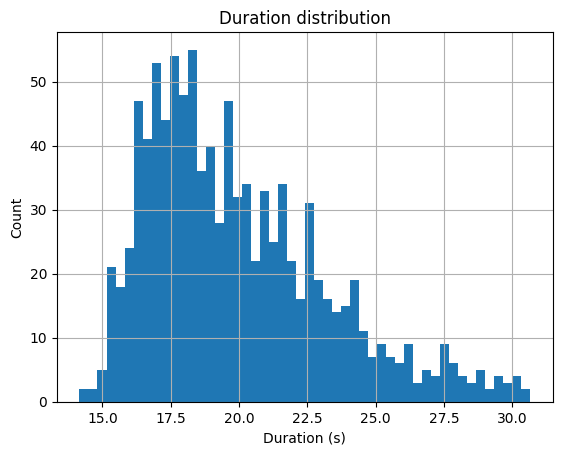

In [ ]:
if "duration" in df.columns:
    print(df["duration"].describe())

    import matplotlib.pyplot as plt
    df["duration"].dropna().hist(bins=50)
    plt.xlabel("Duration (s)")
    plt.ylabel("Count")
    plt.title("Duration distribution")
    plt.show()


In [ ]:
#checking extremes
df.nlargest(5, "duration")[["wav_path", "duration", "text"]]

,wav_path,duration,text
999,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,30.660000,umugore w'mwirabura ufite akana k'irabura agaf...
673,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,30.485333,umusaza ufite imisatsi y'umukara n'umweru ndet...
998,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,30.240000,iyi ni inzu nshya y'ubuvuzi harimo intebe hari...
315,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,30.180000,mu cyumba cyo kwa muganga gikorerwamo ubuvuzi ...
997,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,30.120000,ahantu mu nyubako ubona ko ari kwa muganga has...


In [ ]:
df.nsmallest(5, "duration")[["wav_path", "duration", "text"]]

,wav_path,duration,text
674,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,14.16,icyumba bavuriramo abarwayi harimo amarido y'u...
675,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,14.46,abantu benshi bari mu cyumba bamwe barahagaze ...
0,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,14.70,ahantu hari uducupa tubiri dusa umuhondo imifu...
1,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,14.76,inyubako y'ibitaro by'i nyanza itangirwamo ser...
316,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,14.94,inyubako zigizwe n'amabati y'ubururu amatafari...


Loudness(LUFS) distribution

count    1000.000000
mean      -26.809200
std         6.994645
min       -56.100000
25%       -30.200000
50%       -25.300000
75%       -22.900000
max       -10.200000
Name: LUFS, dtype: float64


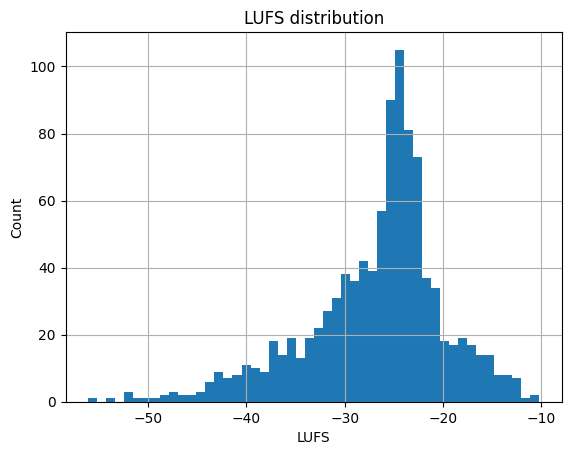

In [ ]:
if "LUFS" in df.columns:
    print(df["LUFS"].describe())
    df["LUFS"].dropna().hist(bins=50)
    plt.xlabel("LUFS")
    plt.ylabel("Count")
    plt.title("LUFS distribution")
    plt.show()


Text Length stats(tokens/characters)

In [ ]:
df["text_len_chars"] = df["text"].str.len()
df["text_len_words"] = df["text"].str.split().str.len()

df[["text_len_chars", "text_len_words"]].describe()


,text_len_chars,text_len_words
count,999.000000,999.000000
mean,207.144144,28.553554
std,57.083204,8.250152
min,67.000000,8.000000
25%,166.500000,23.000000
50%,198.000000,27.000000
75%,236.500000,33.000000
max,528.000000,71.000000


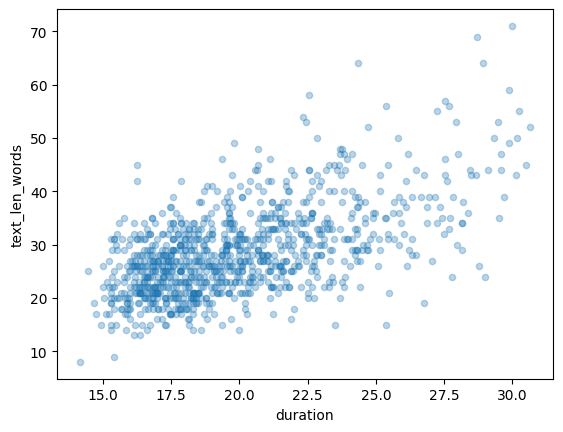

In [ ]:
if "duration" in df.columns:
    df.plot.scatter("duration", "text_len_words", alpha=0.3)


Metadata balance(gender, age_group, location)

In [ ]:
for col in ["gender", "age_group", "location"]:
    if col in df.columns:
        print(f"\n== {col} ==")
        print(df[col].value_counts(dropna=False))



== gender ==
gender
Male      633
Female    366
N/A         1
Name: count, dtype: int64

== age_group ==
age_group
18-24    527
25-35    399
36-49     52
50+       22
Name: count, dtype: int64

== location ==
location
Kigali       382
Huye         282
None         226
Nyagatare     51
Ahandi        44
kigali         7
Musanze        7
 Ahandi        1
Name: count, dtype: int64


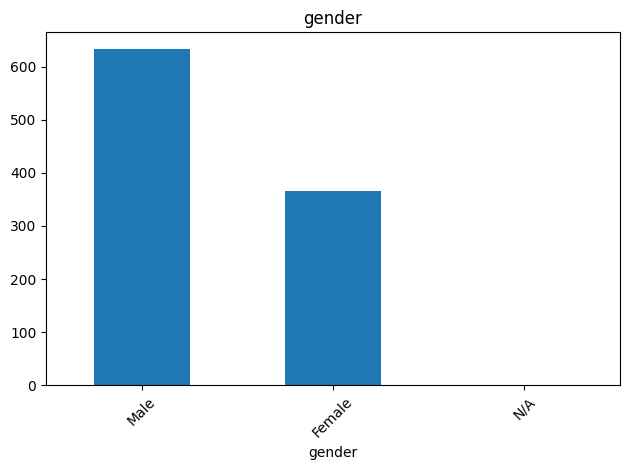

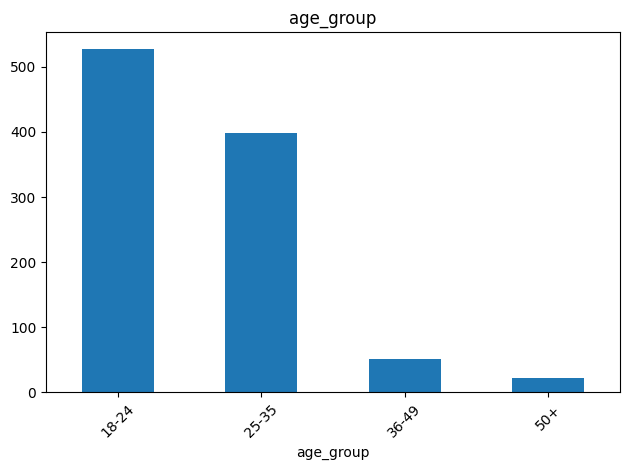

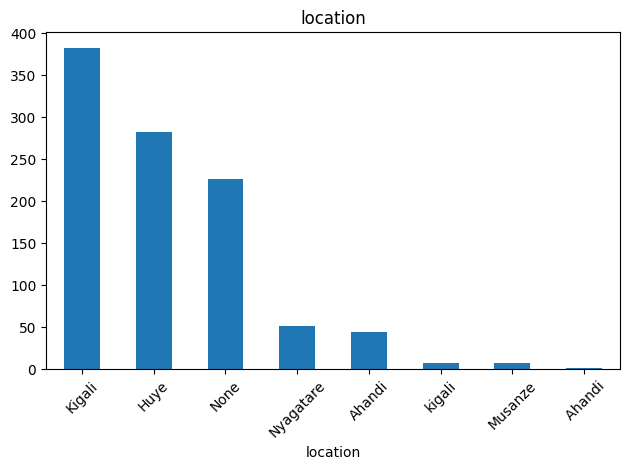

In [ ]:
for col in ["gender", "age_group", "location"]:
    if col in df.columns:
        df[col].value_counts(dropna=False).plot(kind="bar")
        plt.title(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


Total hours of audio

In [ ]:
if "duration" in df.columns:
    total_hours = df["duration"].sum() / 3600
    print("Total hours in subset:", total_hours)


Total hours in subset: 5.533625331081361


In [ ]:
df.sample(5)[["wav_path", "duration", "text"]]


,wav_path,duration,text
565,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,20.88,umusore mu kigero cy'imyaka makumyabiri n'itat...
437,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,17.82,umuturage ubarirwa mu cyigero cy'imyaka mirong...
623,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,22.92,umugore uteruye umwana ku bibero bye yegereye ...
433,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,17.76,ikigo nderabuzima cya matyazo aha ni ahatangir...
592,/content/drive/MyDrive/du_asr_subset/wav_16k/d...,21.96,ni muri laboratwari aho bamwe bari gusobanurir...


In [ ]:
from IPython.display import Audio, display

row = df.sample(1).iloc[0]
display(Audio(filename=row["wav_path"]))
print(row["text"])


ababyeyi baje gukingiza abana babo baricaye bategereje guhura na muganga buri mwana wese bamuteruye mu bibero barishimye kandi baranezerewe kuko abana babo bose bameze neza


### Model Training
Now that we have a better understanding of the dataset, we can move into selecting a base model and beging training.

In [3]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import LoraConfig, get_peft_model


#model
model_name = "openai/whisper-small"

processor = WhisperProcessor.from_pretrained(model_name, language='kinyarwanda', task = 'transcribe')
model = WhisperForConditionalGeneration.from_pretrained(model_name)

model.config.use_cache = False
#freezing model parameters
for parameter in model.parameters():
  parameter.requires_grad = False


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Model loaded successfully and parameters have been frozen.

Time to add `adapters`, and since we're using **Whisper** we'll also use `LoRA adapters`.


In [4]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout = 0.02,
    target_modules = ['q_proj', 'v_proj'],
    task_type ='SEQ_2_SEQ_LM',
    bias = 'none'
)

#adding adapters
model = get_peft_model(model, lora_config)

model.print_trainable_parameters()


trainable params: 1,769,472 || all params: 243,504,384 || trainable%: 0.7267


Removing examples that lack text before we do the mapping.

Now comes the sample dataset loading.

In [5]:
from datasets import load_dataset

#metedata json file path
meta_path = '/content/drive/MyDrive/du_asr_subset/metadata/subset_metadata_20251115_163600.jsonl'

dataset = load_dataset(
    'json',
    data_files = meta_path,
    split = 'train'
)

#add randomness
dataset = dataset.shuffle(seed=21)

dataset[0].keys()

Generating train split: 0 examples [00:00, ? examples/s]

dict_keys(['id', 'wav_path', 'shard_idx', 'audio_member', 'audio_basename', 'text', 'raw_text', 'duration', 'LUFS', 'age_group', 'gender', 'location'])

In [6]:
print("Before filtering:", len(dataset))

dataset = dataset.filter(lambda x: x.get("text") not in [None, ""])

print("After filtering:", len(dataset))

Before filtering: 1000


Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

After filtering: 999


In [ ]:
dataset[-1].keys()

dict_keys(['id', 'wav_path', 'shard_idx', 'audio_member', 'audio_basename', 'text', 'raw_text', 'duration', 'LUFS', 'age_group', 'gender', 'location'])

### Feature Extraction
We need to extract features and create tokens.

In [7]:
"""
def extractor(batch):
    Process a single dataset example by loading the corresponding audio file,
    extracting Whisper-compatible input features, and tokenizing the transcript.

  Parameters
    batch : dict
        A dictionary representing one dataset row. Expected keys:
        - "wav_path": str
            Filepath to a 16 kHz WAV audio file.
        - "text": str
            Transcript associated with the audio.

  Processing Steps
    1. Loads the audio at 16 kHz using librosa.
    2. Passes the audio samples through Whisper's feature extractor to generate
       log-mel spectrogram features used as model input.
    3. Tokenizes the transcript into integer token IDs using Whisper's tokenizer.

    Returns:
    dict
        The input dictionary updated with two new keys:
        - "input_features": list[float]
            Whisper log-mel spectrogram features (model input).
        - "labels": torch.Tensor
            Token IDs representing the target transcription (model output labels).
    This function is intended to be used with `dataset.map(...)` and prepares each
    example for training a sequence-to-sequence ASR model such as Whisper.
"""

# def extractor(batch):
#   #load the wav files
#   import librosa

#   audio, sr = librosa.load(batch['wav_path'], sr=16000)
#   batch['input_features'] = processor.feature_extractor(audio, sampling_rate = 16000).input_features[0]

#   #tokenization
#   batch['labels'] = processor.tokenizer(batch['text'], return_tensors='pt').input_ids[0]

#   return batch

def extractorr(batch):
  #load the wav files
  import librosa

  audio, sr = librosa.load(batch['wav_path'], sr=16000)
  batch['input_features'] = processor.feature_extractor(audio, sampling_rate = 16000).input_features[0]

  #tokenization
  batch['labels'] = processor.tokenizer(batch['text'], return_tensors=None).input_ids

  return batch

In [8]:

#apply the function to our dataset
cleaned_dataset = dataset.map(extractorr, remove_columns=dataset.column_names)

cleaned_dataset[0].keys()

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

dict_keys(['input_features', 'labels'])

In [ ]:
dataset[0].keys()

dict_keys(['id', 'wav_path', 'shard_idx', 'audio_member', 'audio_basename', 'text', 'raw_text', 'duration', 'LUFS', 'age_group', 'gender', 'location'])

In [ ]:
cleaned_dataset[0].keys()

dict_keys(['input_features', 'labels'])

### Trainer Building & Training

In [9]:

@dataclass
class DataCollatorWhisperr:
    processor: WhisperProcessor

    def __call__(self, features):
        # 1. Pad mel spectrograms
        mel_feats = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(
            mel_feats,
            padding=True,
            return_tensors="pt"
        )

        # 2. Pad label sequences
        label_feats = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(
            label_feats,
            padding=True,
            return_tensors="pt"
        )

        # 3. Mask out padding for loss
        labels = labels_batch["input_ids"]
        labels = labels.masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels
        return batch


In [10]:
data_collator = DataCollatorWhisperr(processor)


In [11]:
print("Dataset example keys:", cleaned_dataset[0].keys())
print("Labels type:", type(cleaned_dataset[0]["labels"]))
print("Labels sample:", cleaned_dataset[0]["labels"][:10])
print("Input features shape:",
      len(cleaned_dataset[0]["input_features"]),
      "frames ×",
      len(cleaned_dataset[0]["input_features"][0]),
      "mel bins")


Dataset example keys: dict_keys(['input_features', 'labels'])
Labels type: <class 'list'>
Labels sample: [50258, 50363, 2632, 49353, 3185, 13427, 290, 3837, 408, 2394]
Input features shape: 80 frames × 3000 mel bins


In [ ]:
# def disable_input_ids(*args, **kwargs):
#     kwargs.pop("input_ids", None)
#     return kwargs

# model.prepare_inputs_for_generation = disable_input_ids


In [12]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): WhisperForConditionalGeneration(
      (model): WhisperModel(
        (encoder): WhisperEncoder(
          (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
          (embed_positions): Embedding(1500, 768)
          (layers): ModuleList(
            (0-11): 12 x WhisperEncoderLayer(
              (self_attn): WhisperAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=False)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.02, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): Mo

In [13]:
#training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir = '/content/drive/MyDrive/whisper_adapter_ckpts',
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 2,
    learning_rate = 1e-4,
    warmup_steps = 200,
    save_steps = 500,
    max_steps = 2800,
    fp16 = True,
    logging_steps = 50, #no evalution during first training
    report_to = 'none'
)


from transformers import Trainer
#trainer
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset = cleaned_dataset,
    data_collator = data_collator,
    tokenizer = processor.tokenizer,

)


/tmp/ipython-input-4106129577.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [14]:
def patched_forward(self, *args, **kwargs):
    # remove fields Whisper doesn't use
    bad = [
        "input_ids",
        "attention_mask",
        "decoder_input_ids",
        "decoder_attention_mask",
        "inputs_embeds",
        "decoder_inputs_embeds",
    ]
    for k in bad:
        if k in kwargs:
            del kwargs[k]

    return self.base_model.forward(*args, **kwargs)

model.forward = patched_forward.__get__(model, type(model))


In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Take a small batch from the dataset
batch = data_collator([cleaned_dataset[0], cleaned_dataset[1]])

with torch.no_grad():
    outputs = model(
        input_features=batch["input_features"].to(device),
        labels=batch["labels"].to(device),
    )

print("Forward pass OK. Loss:", float(outputs.loss))


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Forward pass OK. Loss: 4.324008941650391


In [16]:

# #training, watching & checkpointing
train_result = trainer.train()
trainer.save_model("/content/drive/MyDrive/whisper_adapter_ckpts/final_full_trainer_save")


Step,Training Loss
50,3.580500
100,2.833700
150,2.061600
200,1.622600
250,1.389800
300,1.237500
350,1.134600
400,1.069600
450,1.002500
500,0.930000


### Model Evaluation
Lets visualize the performance of this model on the 1000 subset data we had after initial training.

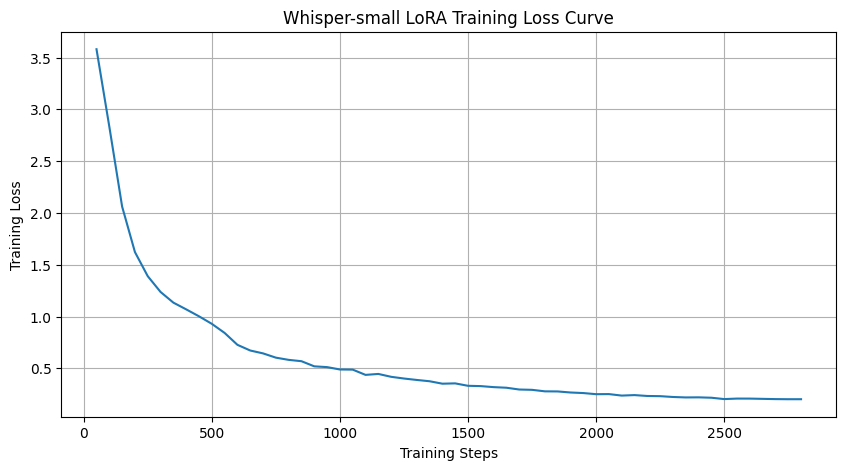

Plotted 56 logged loss points.


In [17]:
import matplotlib.pyplot as plt

# Extract training loss history from the trainer state
log_history = trainer.state.log_history

steps = []
losses = []

for entry in log_history:
    if "loss" in entry and "learning_rate" in entry:  # standard training log entries
        steps.append(entry["step"])
        losses.append(entry["loss"])

# Plot
plt.figure(figsize=(10,5))
plt.plot(steps, losses)
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Whisper-small LoRA Training Loss Curve")
plt.grid(True)
plt.show()

print(f"Plotted {len(losses)} logged loss points.")


From the graph, we can see we had a **stable loss** without divergence and no early overfitting.

The curve is smooth, appears monotonic and stable thus matches expected **Whisper** behaviour.

### Model Tuning
After initial model training on the subset, we can create a **paramete grid** to find the optimal *hyperparameters* for this model.

In [18]:
# ##parameter grid
# param_grid = {
#     'learning_rate': [5e-5, 1e-4, 2e-4],
#     'lora_r' : [8, 16, 32],
#     'lora_alpha': [16, 32, 64],
#     'lora_dropout':[0.01, 0.05],
#     'target_modules': [['q_proj', 'k_proj', 'v_proj'], ['q_proj', 'k_proj', 'v_proj', 'out_proj']],
#     'max_steps' :[1200, 2000]
# }

# above grid has about 216 instances to run and is not optimal
param_grid = [
    #conservative baseline
    {
        "learning_rate": 1e-4,
        "lora_r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.05,
        "target_modules": ["q_proj", "v_proj"],
        "max_steps": 300
    },
    #lower LR
    {
        "learning_rate": 5e-5,
        "lora_r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.05,
        "target_modules": ["q_proj", "v_proj"],
        "max_steps": 300
    },
    #higher rank
    {
        "learning_rate": 1e-4,
        "lora_r": 32,
        "lora_alpha": 64,
        "lora_dropout": 0.05,
        "target_modules": ["q_proj", "v_proj"],
        "max_steps": 300
    },
    #wider module coverage
    {
        "learning_rate": 1e-4,
        "lora_r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.05,
        "target_modules": ["q_proj", "k_proj", "v_proj"],
        "max_steps": 300
    },
    #dropout sweep
    {
        "learning_rate": 1e-4,
        "lora_r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.01,
        "target_modules": ["q_proj", "v_proj"],
        "max_steps": 300
    },
    #high-rank + wider modules
    {
        "learning_rate": 1e-4,
        "lora_r": 32,
        "lora_alpha": 64,
        "lora_dropout": 0.05,
        "target_modules": ["q_proj", "k_proj", "v_proj"],
        "max_steps": 300
    },
]


In [34]:
from transformers import WhisperForConditionalGeneration
from peft import LoraConfig, get_peft_model
import torch

def build_lora_model(cfg):
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
    model.config.forced_decoder_ids = None
    model.config.suppress_tokens = []

    # Freeze Whisper base
    for p in model.parameters():
        p.requires_grad = False

    lcfg = LoraConfig(
        r=cfg["lora_r"],
        lora_alpha=cfg["lora_alpha"],
        lora_dropout=cfg["lora_dropout"],
        target_modules=cfg["target_modules"],
        bias="none",
        task_type="SEQ_2_SEQ_LM",
    )

    model = get_peft_model(model, lcfg)

    # Use your existing monkeypatch
    model.forward = patched_forward.__get__(model, type(model))

    if torch.cuda.is_available():
        model = model.to("cuda")

    return model


In [42]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from pathlib import Path
import torch

tuning_dir = Path("/content/drive/MyDrive/lora_tuning_runs")
tuning_dir.mkdir(parents=True, exist_ok=True)

def run_lora_trial(cfg, idx):
    run_name = f"trial_{idx}_r{cfg['lora_r']}_lr{cfg['learning_rate']}"
    output_dir = tuning_dir / run_name

    model = build_lora_model(cfg)

    training_args = Seq2SeqTrainingArguments(
        output_dir=str(output_dir),
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        learning_rate=cfg["learning_rate"],
        warmup_steps=50,
        max_steps=cfg["max_steps"],
        fp16=True,
        logging_steps=25,
        save_steps=cfg["max_steps"],
        save_total_limit=1,
        report_to="none",
        predict_with_generate=False,
        remove_unused_columns = False,
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=cleaned_dataset,
        data_collator=data_collator,
        tokenizer=processor.feature_extractor,
    )

    trainer.train()

    logs = [x for x in trainer.state.log_history if "loss" in x]
    final_loss = logs[-1]["loss"]

    del model
    torch.cuda.empty_cache()

    return {
        "name": run_name,
        "loss": final_loss,
        "dir": str(output_dir),
        "cfg": cfg
    }


In [ ]:
results = []

for i, cfg in enumerate(param_grid):
    print(f"\n===== Running {i+1}/{len(param_grid)} =====")
    print(cfg)
    out = run_lora_trial(cfg, i+1)
    results.append(out)
    print(f"Final loss: {out['loss']}")

# Sort by loss
results = sorted(results, key=lambda x: x["loss"])

print("\n===== SORTED RESULTS =====")
for r in results:
    print(f"{r['name']} | loss={r['loss']:.4f}")

best_two = results[:2]

print("\n===== BEST TWO CONFIGS =====")
for r in best_two:
    print("\nName:", r["name"])
    print("Loss:", r["loss"])
    print("Config:", r["cfg"])
    print("Checkpoint:", r["dir"])



===== Running 1/6 =====
{'learning_rate': 0.0001, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.05, 'target_modules': ['q_proj', 'v_proj'], 'max_steps': 300}


/tmp/ipython-input-132210506.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
25,3.620100
50,2.943500
75,2.229900
100,1.845200
125,1.699500
150,1.547500
175,1.466800
200,1.427700
225,1.354800
250,1.353300


Final loss: 1.314

===== Running 2/6 =====
{'learning_rate': 5e-05, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.05, 'target_modules': ['q_proj', 'v_proj'], 'max_steps': 300}


/tmp/ipython-input-132210506.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
25,3.682500
50,3.246600
75,2.693100
100,2.295200
125,2.086100
150,1.896100
175,1.784600
200,1.750000
225,1.667900
250,1.654900


Final loss: 1.6246

===== Running 3/6 =====
{'learning_rate': 0.0001, 'lora_r': 32, 'lora_alpha': 64, 'lora_dropout': 0.05, 'target_modules': ['q_proj', 'v_proj'], 'max_steps': 300}


/tmp/ipython-input-132210506.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
25,3.533200
50,2.667300
75,1.947900
100,1.622700
125,1.507700
150,1.357300
175,1.284800
200,1.238900
225,1.166100
250,1.167400


Final loss: 1.121

===== Running 4/6 =====
{'learning_rate': 0.0001, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.05, 'target_modules': ['q_proj', 'k_proj', 'v_proj'], 'max_steps': 300}


/tmp/ipython-input-132210506.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
25,3.602100
50,2.891300
75,2.158900
100,1.768600
125,1.635400


In [37]:
[v for v in globals().keys() if "train" in v.lower() or "dataset" in v.lower()]


['Seq2SeqTrainingArguments',
 'Seq2SeqTrainer',
 'load_dataset',
 'dataset',
 'cleaned_dataset',
 'training_args',
 'Trainer',
 'trainer',
 'train_result',
 'train_lora_run']

In [ ]:
### WER evaluation on Health Dataset
from datasets import load_dataset
from jiwer import wer

def evaluate_wer(model, processor, eval_dataset):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    preds = []
    refs = []

    for item in eval_dataset:
        audio = item["audio"]

        inputs = processor(
            audio["array"],
            sampling_rate=audio["sampling_rate"],
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            pred_ids = model.generate(inputs["input_features"])
        transcription = processor.batch_decode(pred_ids, skip_special_tokens=True)[0]

        preds.append(transcription)
        refs.append(item["text"])

    return wer(refs, preds), preds, refs

# Example usage:
# health = load_dataset("DigitalUmuganda/Health", split="test")
# baseline_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
# baseline_wer, _, _ = evaluate_wer(baseline_model, processor, health)
3

Loading Afrivoice Kinyarwanda-health domain

In [ ]:
from huggingface_hub import login
login()  # will open a link / ask for token interactively


In [ ]:
from huggingface_hub import login

login()



In [ ]:
from datasets import load_dataset
# afrivoice = load_dataset("DigitalUmuganda/Afrivoice_Kinyarwanda", name="health")
# afrivoice



In [ ]:
# def ds_to_df(ds_split):
#     return pd.DataFrame(ds_split)

# df_train_full = ds_to_df(afrivoice["train"])
# df_val_full   = ds_to_df(afrivoice["validation"])
# df_test_full  = ds_to_df(afrivoice["test"])

# print(len(df_train_full), len(df_val_full), len(df_test_full))

In [ ]:
# MAX_DURATION = 30.0  # seconds

# df_train_filt = df_train_full[df_train_full["duration"] <= MAX_DURATION].reset_index(drop=True)
# df_val_filt   = df_val_full[df_val_full["duration"] <= MAX_DURATION].reset_index(drop=True)

# print("Train (filtered) rows:", len(df_train_filt))
# print("Val   (filtered) rows:", len(df_val_filt))


### subsample to colab-friendly
- Train subset ----> 20-50 hours
- Val subset ------> a few thousand


In [ ]:
def pick_hours(df, target_hours):
    """Greedy sample from shuffled df until we hit target_hours."""
    target_sec = target_hours * 3600
    df_shuf = df.sample(frac=1, random_state=42).reset_index(drop=True)
    cum_dur = df_shuf["duration"].cumsum()
    mask = cum_dur <= target_sec
    return df_shuf[mask].reset_index(drop=True)

TRAIN_HOURS = 30.0  # adjust if you want more/less
VAL_UTTS    = 2000  # number of val utterances to keep

df_train_sub = pick_hours(df_train_filt, TRAIN_HOURS)

if len(df_val_filt) > VAL_UTTS:
    df_val_sub = df_val_filt.sample(VAL_UTTS, random_state=42).reset_index(drop=True)
else:
    df_val_sub = df_val_filt.copy()

print("Train subset rows:", len(df_train_sub))
print("Train subset hours:", df_train_sub["duration"].sum() / 3600)
print("Val subset rows:", len(df_val_sub))
print("Val subset hours:", df_val_sub["duration"].sum() / 3600)


In [ ]:
# !pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=780208ce7282f8321f564186ec248446367123eea19b7ff0125b5d53b227e8ae
  Stored in directory: /root/.cache/pip/wheels/26/21/0c/c26e09dff860a9071683e279445262346e008a9a1d2142c4ad
Successfully built ffmpeg


Saving subsets on drive

In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/afrivoice_health_subset"
os.makedirs(BASE_DIR, exist_ok=True)

train_csv = os.path.join(BASE_DIR, "health_train_subset.csv")
val_csv   = os.path.join(BASE_DIR, "health_val_subset.csv")
test_csv  = os.path.join(BASE_DIR, "health_test_full.csv")  # or _subset if you filter

df_train_sub.to_csv(train_csv, index=False)
df_val_sub.to_csv(val_csv, index=False)
df_test.to_csv(test_csv, index=False)

train_csv, val_csv, test_csv
